In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [36]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/'
SRS_gain = 10 # gain on the SRS bandpass filter
peak_threshold = 125 # upper bound of pedestal
breakdown = 27.4 # breakdown voltage of the SiPM
pedestal = 50 # center of noise pedestal peak

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 10 files


In [25]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2)) 

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [26]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [60]:
def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, binsize=10):
    # rebin data to make the histogram bins less small
    x, y = rebin_histogram(x_data, y_data, binsize)
    
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    peaks_index, _ = scipy.signal.find_peaks(y, distance=min_distance)

    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    peak_params = []
    peak_number = 1 # corresponds to single photoelectron
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue

        # Initial guess for the Gaussian parameters
        amplitude_guess = y[peak]
        mean_guess = x[peak]
        standard_deviation_guess = 1
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # finding the section of the data around the given peak
        if voltage < 30:
            peak_range = 150
        else:
            peak_range = 500
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - 10))
        else:
            cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - peak_range))
        peak_x = x[cut]
        peak_y = y[cut]
        
        print('Peak: ', peak)
        peak_number+=1 # (goes to n*spe until it reaches max_peak)
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            print('Guess: ', initial_guess)
            print('Params: ', params)
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            peak_params.append([peak, np.nan, np.nan])
            xx = np.linspace( x[peak] - 2*standard_deviation_guess, x[peak] + 2*standard_deviation_guess, 100 )
            plt.plot(xx, gauss_fun(xx, *initial_guess), 'b' )
        
        peak_params.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
    
    # Plot the original spectrum and the fitted Gaussian peaks
#         plt.plot(peak_x, peak_y, color='b')
        plt.plot(x[peak], y[peak], 'o', label='peaks')
#         plt.plot(x, gauss_fun(x, *initial_guess), color='r')
        plt.plot(x, gauss_fun(x, *params))

    plt.show()
    return np.array(peak_params), x, y

Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_33.90OV_source_0.h5
Distance:  10
Peak:  16
Guess:  [574, 165.0302197802198, 1]
Params:  [574.         165.03021978   1.        ]
Peak:  31
Guess:  [229, 315.0576923076923, 1]
Params:  [229.         315.05769231   1.        ]
Peak:  47
Guess:  [129, 475.0869963369963, 1]
Params:  [129.         475.08699634   1.        ]
Peak:  62
Guess:  [73, 625.1144688644689, 1]
Params:  [ 73.         625.11446886   1.        ]
Peak:  77
Guess:  [58, 775.1419413919414, 1]
Params:  [ 58.         775.14194139   1.        ]


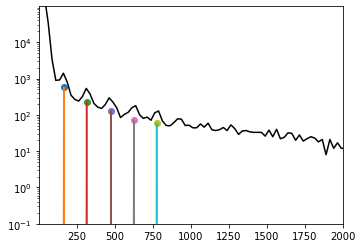

[[  2.         165.03021978          inf]
 [  3.         315.05769231          inf]
 [  4.         475.08699634          inf]
 [  5.         625.11446886          inf]
 [  6.         775.14194139          inf]]


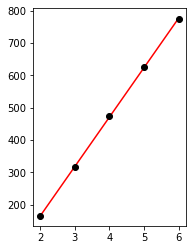

Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_33.40OV_source_0.h5
Distance:  10
Peak:  15
Guess:  [635, 155.02838827838826, 1]
Params:  [635.         155.02838828   1.        ]
Peak:  28
Guess:  [255, 285.05219780219784, 1]
Params:  [255.        285.0521978   1.       ]
Peak:  43
Guess:  [121, 435.0796703296703, 1]
Params:  [121.         435.07967033   1.        ]
Peak:  57
Guess:  [81, 575.1053113553114, 1]
Params:  [ 81.         575.10531136   1.        ]
Peak:  71
Guess:  [48, 715.1309523809524, 1]
Params:  [ 48.         715.13095238   1.        ]


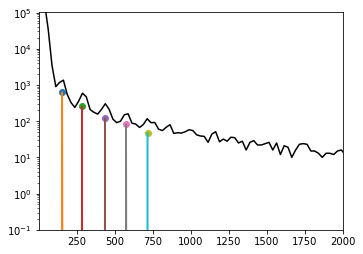

[[  2.         155.02838828          inf]
 [  3.         285.0521978           inf]
 [  4.         435.07967033          inf]
 [  5.         575.10531136          inf]
 [  6.         715.13095238          inf]]


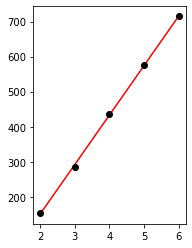

Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_32.90OV_source_0.h5
Distance:  10
Peak:  14
Guess:  [689, 145.0265567765568, 1]
Params:  [689.         145.02655678   1.        ]
Peak:  26
Guess:  [269, 265.0485347985348, 1]
Params:  [269.        265.0485348   1.       ]
Peak:  40
Guess:  [138, 405.0741758241758, 1]
Params:  [138.         405.07417582   1.        ]
Peak:  53
Guess:  [84, 535.0979853479853, 1]
Params:  [ 84.         535.09798535   1.        ]
Peak:  66
Guess:  [55, 665.1217948717949, 1]
Params:  [ 55.         665.12179487   1.        ]


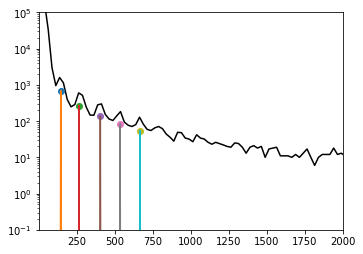

[[  2.         145.02655678          inf]
 [  3.         265.0485348           inf]
 [  4.         405.07417582          inf]
 [  5.         535.09798535          inf]
 [  6.         665.12179487          inf]]


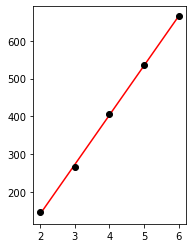

Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_32.40OV_source_0.h5
Distance:  10
Peak:  13
Guess:  [724, 135.02472527472526, 1]
Params:  [724.         135.02472527   1.        ]
Peak:  24
Guess:  [279, 245.04487179487177, 1]
Params:  [279.         245.04487179   1.        ]
Peak:  36
Guess:  [124, 365.0668498168498, 1]
Params:  [124.         365.06684982   1.        ]
Peak:  48
Guess:  [67, 485.0888278388278, 1]
Params:  [ 67.         485.08882784   1.        ]
Peak:  60
Guess:  [49, 605.1108058608058, 1]
Params:  [ 49.         605.11080586   1.        ]


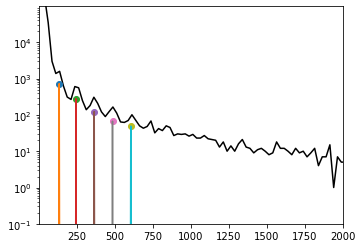

[[  2.         135.02472527          inf]
 [  3.         245.04487179          inf]
 [  4.         365.06684982          inf]
 [  5.         485.08882784          inf]
 [  6.         605.11080586          inf]]


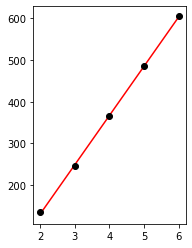

Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_31.90OV_source_0.h5
Distance:  10
Peak:  22
Guess:  [296, 225.04120879120882, 1]
Params:  [296.         225.04120879   1.        ]
Peak:  34
Guess:  [142, 345.0631868131868, 1]
Params:  [142.         345.06318681   1.        ]
Peak:  44
Guess:  [64, 445.08150183150184, 1]
Params:  [ 64.         445.08150183   1.        ]
Peak:  55
Guess:  [55, 555.1016483516484, 1]
Params:  [ 55.         555.10164835   1.        ]
Peak:  67
Guess:  [26, 675.1236263736264, 1]
Params:  [ 26.         675.12362637   1.        ]


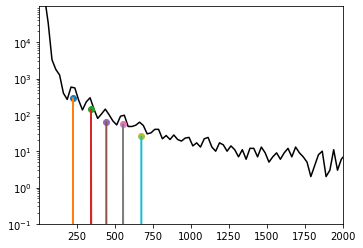

[[  2.         225.04120879          inf]
 [  3.         345.06318681          inf]
 [  4.         445.08150183          inf]
 [  5.         555.10164835          inf]
 [  6.         675.12362637          inf]]


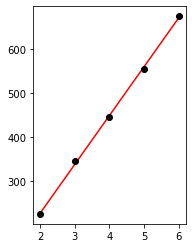

Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_31.40OV_source_0.h5
Distance:  5
Peak:  19
Guess:  [254, 195.03571428571428, 1]
Params:  [254.         195.03571429   1.        ]
Peak:  30
Guess:  [118, 305.0558608058608, 1]
Params:  [118.         305.05586081   1.        ]
Peak:  38
Guess:  [73, 385.0705128205128, 1]
Params:  [ 73.         385.07051282   1.        ]
Peak:  43
Guess:  [24, 435.0796703296703, 1]
Params:  [ 24.         435.07967033   1.        ]
Peak:  48
Guess:  [42, 485.0888278388278, 1]
Params:  [ 42.         485.08882784   1.        ]


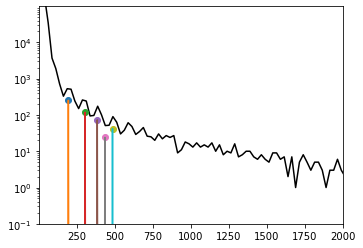

[[  2.         195.03571429          inf]
 [  3.         305.05586081          inf]
 [  4.         385.07051282          inf]
 [  5.         435.07967033          inf]
 [  6.         485.08882784          inf]]


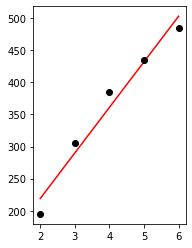

Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_30.90OV_source_0.h5
Distance:  5
Peak:  17
Guess:  [285, 175.03205128205127, 1]
Params:  [285.         175.03205128   1.        ]
Peak:  26
Guess:  [119, 265.0485347985348, 1]
Params:  [119.        265.0485348   1.       ]
Peak:  34
Guess:  [61, 345.0631868131868, 1]
Params:  [ 61.         345.06318681   1.        ]
Peak:  43
Guess:  [41, 435.0796703296703, 1]
Params:  [ 41.         435.07967033   1.        ]
Peak:  52
Guess:  [28, 525.0961538461538, 1]
Params:  [ 28.         525.09615385   1.        ]


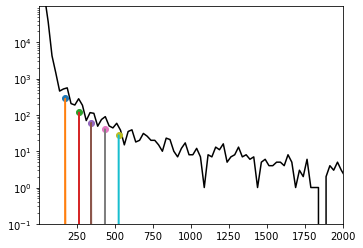

[[  2.         175.03205128          inf]
 [  3.         265.0485348           inf]
 [  4.         345.06318681          inf]
 [  5.         435.07967033          inf]
 [  6.         525.09615385          inf]]


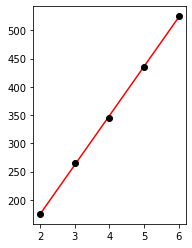

Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_30.40OV_source_0.h5
Distance:  1
Peak:  15
Guess:  [252, 155.02838827838826, 1]
Params:  [252.         155.02838828   1.        ]
Peak:  22
Guess:  [101, 225.04120879120882, 1]
Params:  [101.         225.04120879   1.        ]
Peak:  26
Guess:  [53, 265.0485347985348, 1]
Params:  [ 53.        265.0485348   1.       ]
Peak:  30
Guess:  [57, 305.0558608058608, 1]
Params:  [ 57.         305.05586081   1.        ]
Peak:  36
Guess:  [39, 365.0668498168498, 1]
Params:  [ 39.         365.06684982   1.        ]


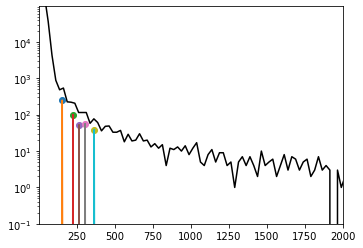

[[  2.         155.02838828          inf]
 [  3.         225.04120879          inf]
 [  4.         265.0485348           inf]
 [  5.         305.05586081          inf]
 [  6.         365.06684982          inf]]


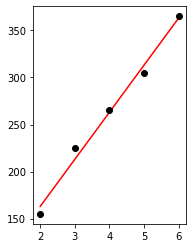

Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_29.90OV_source_0.h5
Distance:  1
Peak:  12
Guess:  [265, 125.02289377289377, 1]
Params:  [265.         125.02289377   1.        ]
Peak:  19
Guess:  [103, 195.03571428571428, 1]
Params:  [103.         195.03571429   1.        ]
Peak:  25
Guess:  [55, 255.0467032967033, 1]
Params:  [ 55.        255.0467033   1.       ]
Peak:  30
Guess:  [44, 305.0558608058608, 1]
Params:  [ 44.         305.05586081   1.        ]
Peak:  37
Guess:  [29, 375.06868131868134, 1]
Params:  [ 29.         375.06868132   1.        ]


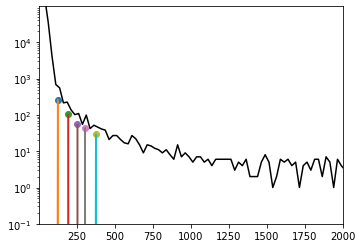

[[  2.         125.02289377          inf]
 [  3.         195.03571429          inf]
 [  4.         255.0467033           inf]
 [  5.         305.05586081          inf]
 [  6.         375.06868132          inf]]


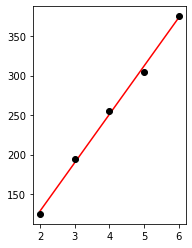

Working on file #9: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step6/mca_keith_29.40OV_source_0.h5
Distance:  1
Peak:  19
Guess:  [54, 195.03571428571428, 1]
Params:  [ 54.         195.03571429   1.        ]
Peak:  24
Guess:  [30, 245.04487179487177, 1]
Params:  [ 30.         245.04487179   1.        ]
Peak:  28
Guess:  [28, 285.05219780219784, 1]
Params:  [ 28.        285.0521978   1.       ]
Peak:  31
Guess:  [22, 315.0576923076923, 1]
Params:  [ 22.         315.05769231   1.        ]
Peak:  33
Guess:  [19, 335.0613553113553, 1]
Params:  [ 19.         335.06135531   1.        ]


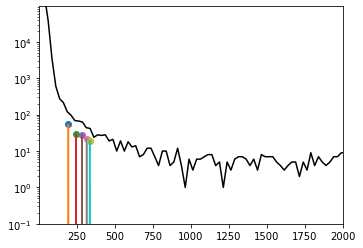

[[  2.         195.03571429          inf]
 [  3.         245.04487179          inf]
 [  4.         285.0521978           inf]
 [  5.         315.05769231          inf]
 [  6.         335.06135531          inf]]


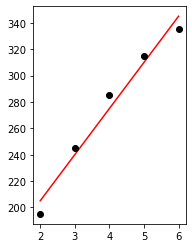

In [67]:
guess_1pe = 150 #110 * SRS_gain/10 - pedestal ## based on highest gain data
guess_sig = 0.1

#distances = [40, 35, 30, 25, 25, 25, 20, 15, 15, 15] # step5, binsize = 25
distances = [10, 10, 10, 10, 10, 5, 5, 1, 1, 1]

gain_vs_volts = []
for i,(file, dist) in enumerate(zip(file_list, distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data



    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 25)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 2000)

    if(len(gain_vs_volts) > 0):
        guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    pe_locs, post_bin_x, post_bin_y = find_peaks_and_fit(bin_num, mca_hist, file_volts, min_distance=dist)
#     plt.xlim(0, guess_1pe*6)


    plt.subplot(1,2,2)
    print(pe_locs)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    fpts = ~np.isnan(pe_locs[:,1])
    if(np.sum(fpts) < 3):
        continue
    gain_bp, gain_bc = curve_fit( lin_fun, pe_locs[fpts, 0], pe_locs[fpts, 1] )

    xx = pe_locs[fpts, 0]
    plt.plot( xx, lin_fun(xx, *gain_bp), 'r')

    gain_vs_volts.append( [file_volts, gain_bp[0], np.sqrt(gain_bc[0,0]), file_wavelength] )

    plt.show()
    

In [64]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
gain_vs_volts = np.array(gain_vs_volts)
wl_to_use = gain_vs_volts[:,3] == 405
print(wl_to_use)
print(np.array(gain_vs_volts[wl_to_use,:]))

False
[]


/gpfs/gibbs/project/david_moore/mpw46/conda_envs/new_env1/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


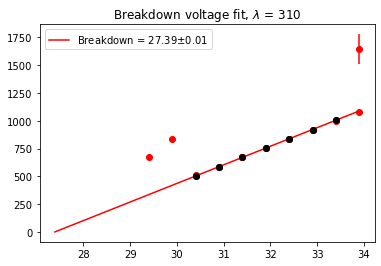

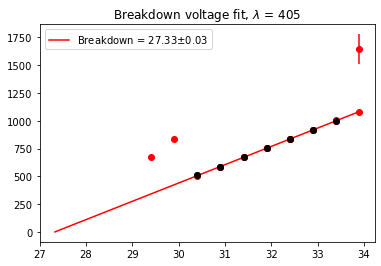

In [49]:
# change to have linear fit for both leds -- will need to use file_parts[-2][:-2] to separate them out -- will need to loop in block above

gain_vs_volts = np.array(gain_vs_volts[::-1])
wavelength = [310, 405]

voltages_to_exclude = [29.4, 29.9, 33.9]

for wl in wavelength:

    rows_to_skip = []
    for v in gain_vs_volts[:,0]:
        if(v in voltages_to_exclude):
            rows_to_skip.append(False)
        else:   
            rows_to_skip.append(True)
    rows_to_skip = np.array(rows_to_skip)
    
    rows_to_use = gain_vs_volts[:,3] == wl #select rows with the desired wavelength
    rows_to_use = rows_to_use & rows_to_skip
    bd_bp, bd_bc = curve_fit(lin_fun, gain_vs_volts[rows_to_use, 0], gain_vs_volts[rows_to_use, 1], sigma=gain_vs_volts[rows_to_use, 2])

    plt.figure()
    plt.errorbar(gain_vs_volts[:,0], gain_vs_volts[:,1], yerr=gain_vs_volts[:,2], fmt='ro')
    plt.errorbar(gain_vs_volts[rows_to_use,0], gain_vs_volts[rows_to_use,1], yerr=gain_vs_volts[rows_to_use,2], fmt='ko')
    #plt.errorbar(gain_vs_volts[~rows_to_use,0], gain_vs_volts[~rows_to_use,1], yerr=gain_vs_volts[~rows_to_use,2], fmt='ro')
    xx = np.linspace(bd_bp[1], np.max(gain_vs_volts[:,0]), 100)
    plt.plot(xx, lin_fun(xx,*bd_bp), 'r', label="Breakdown = %.2f$\pm$%.2f"%(bd_bp[1], np.sqrt(bd_bc[1,1])))
    plt.title("Breakdown voltage fit, $\lambda$ = %d"%wl)
    plt.legend()
    plt.show()

In [45]:
print(rows_to_use)

[False False False  True False  True False  True False  True False  True
 False  True False  True False False]


Found 4 files
Working on file #0: C:/Data/20230213/Step16\mca_keith_31.40OV_source_3.h5


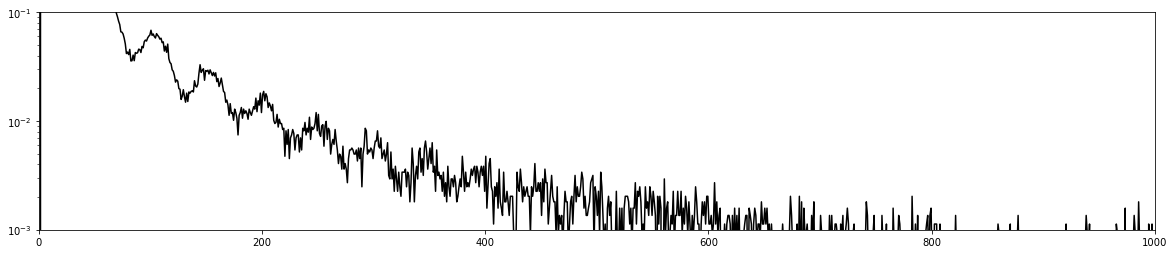

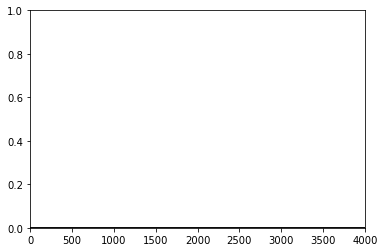

In [107]:
## Plot latest file

path = r"C:/Data/20230213/Step16/"

type_list = ['source']#, '405', '310']
col_list = ['k', 'b', 'purple']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
fig2 = plt.figure(figsize=(6,4))
for j,t in enumerate(type_list):
    file_list = natsort.realsorted(glob.glob(path + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))


    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 1)

        if(len(norm_range)==2):
            gpts = (b < norm_range[1]) & (b > norm_range[0])
            norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, color=col_list[j])
        plt.ylim(1e-3,1e-1)
        plt.xlim(0,1000)

        plt.figure(fig2.number)
        plt.plot(b, c/norm_fac - ref_hist, color=col_list[j])
        plt.ylim(0,1)
        plt.xlim(0,4000)

plt.show()

In [ ]:
# def find_peaks_and_fit(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, binsize=25):
#     # try different bin sizes above
#     # rebin data to make the histogram bins less small
#     x, y = rebin_histogram(x_data, y_data, binsize)
    
#     # Find the peaks in the spectrum using the find_peaks function from scipy.signal
#     peaks_index, _ = scipy.signal.find_peaks(y, distance=min_distance)

#     # Fit each peak with a Gaussian function using the curve_fit function from scipy
#     peak_params = []
#     peak_number = 1 # corresponds to single photoelectron
#     for peak in peaks_index:
#         if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
#             break
# #         print(peak)
#         if peak < min_thresh:
#             continue

#         # Initial guess for the Gaussian parameters
#         amplitude_guess = y[peak]
#         mean_guess = x[peak]
#         standard_deviation_guess = 50 # can play with as well
#         initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]

#         # finding the section of the data around the given peak
#         if voltage < 30:
#             peak_range = 150  # peaks spread out at higher voltages
#         else:
#             peak_range = 500
#         if peak_number == 1: # trying to not include the pedestal for the first peak
#             cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - 200))
#         else:
#             cut = (x < (x[peak] + peak_range)) & (x > (x[peak] - peak_range))
#         peak_x = x[cut]
#         peak_y = y[cut]
        
#         print('Peak: ', peak)
#         peak_number+=1 # goes to n*spe until it reaches max_peak

#         # Perform the curve fitting
#         try:
#             params, params_covariance = curve_fit(gauss_fun, x, y, p0=initial_guess)
#             print('Guess: ', initial_guess)
#             print('Params: ', params)
#         except RuntimeError as r:
#             print('fit failed')
#             # if  curve fit doesn't work we will use peak amplitude and center from find_peaks
#             peak_params.append([peak, np.nan, np.nan])
#             xx = np.linspace( x[peak] - 2*standard_deviation_guess, x[peak] + 2*standard_deviation_guess, 100)
#             plt.plot( xx, gauss_fun(xx, *initial_guess), 'b')
#             continue
#         peak_params.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
#         peak_number+=1 # (goes to n*spe until it reaches max_peak)
    
#     # Plot the original spectrum and the fitted Gaussian peaks
#         plt.plot(x[peak], y[peak], 'o', label='peaks')
# #     plt.plot(x, y, 'o', label='Original spectrum')
#         plt.plot(x, gauss_fun(x, *params), label='Fitted peak')
#     #for params in peak_params:
#         #print(params)
#         #plt.plot(x, gauss_fun(x, *params), label='Fitted peak')
#     #plt.legend()
#     plt.show()
#     return np.array(peak_params), x, y